## SYDE556/750 Assignment 2: Spiking Neurons

- Due Date: Feb 18th: Assignment #2 (due at midnight) 
- Total marks: 20 (20% of final grade)
- Late penalty: 1 mark per day
- It is recommended that you use a language with a matrix library and graphing capabilities.  Two main suggestions are Python and MATLAB.
- *Do not use any code from Nengo*

In [1349]:
%pylab inline
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')
pi = np.pi

Populating the interactive namespace from numpy and matplotlib


In [1350]:
def getRMS(sig):
    return np.sqrt(1/float(len(sig)) * np.sum(sig**2))

## 1) Generating a random input signal

### 1.1) Gaussian white noise

Create a function called that generates a randomly varying $x(t)$ signal chosen from a white noise distribution.  Call it 'generate_signal' and ensure that it returns $x(t)$ and $X(\omega)$.

The inputs to the function are:

- ``T``: the length of the signal in seconds
- ``dt``: the time step in seconds
- ``rms``: the root mean square power level of the signal.  That is, the resulting signal should have $\sqrt{{1 \over T} \int{x(t)^2}dt}=rms$
- ``limit``: the maximum frequency for the signal (in Hz)
- ``seed``: the random number seed to use (so we can regenerate the same signal again)

Notes:

- To do Fourier transforms in MATLAB, see [here](http://www.mathworks.com/help/matlab/ref/fft.html)
- To do Fourier transforms in Python, see [here](http://docs.scipy.org/doc/numpy/reference/routines.fft.html)    
- In both cases, the transform takes you from $t$ to $\omega$ (or back the other way).  Importantly, $\omega$ is frequency in *radians*, not in Hz.  
- $\Delta \omega$ will be $2 \pi / T$
- To keep the signal real, $X(\omega)=X(-\omega)^*$ (the complex conjugate: the real parts are equal, and the imaginary parts switch sign)
- When randomly generating $X(\omega)$ values, sample them from a Normal distribution $N(\mu=0,\sigma=1)$.  Remember that these are complex numbers, so sample twice from the distribution; once for the real component and once for the imaginary.
- To implement the ``limit``, set all $X(\omega)$ components with frequencies above the limit to 0
- To implement the ``rms``, generate the signal, compute its RMS power ($\sqrt{{1 \over T} \int{x(t)^2}dt}=rms$) and rescale so it has the desired power.

In [1351]:
# doing it this way give the same result
def generate_signal(T, dt, rms, limit, seed=None):
    if (seed):
        np.random.seed(seed)
    Len = T/dt
    
    t = np.linspace(0, T, T/dt)
    sig = np.random.normal(0,1,t.shape)                   # generate a random normal time domain signal (white noise)
    w_pos = np.linspace(0,np.int(1/(2*dt)), (T/(2*dt)+1))
    
    SIG = fft.rfft(sig)
    FILT = np.piecewise(w_pos, [w_pos <= limit, w_pos > limit], [lambda w_pos: 1, lambda w_pos: 0]) # Create a box filter
    FILT[0] = 0        # DC = 0
    SIG2 = SIG*FILT    # Apply the box filter
    
    sig2 = fft.irfft(SIG2)
    sig2 = sig2 * rms/getRMS(sig2)
    SIG2 = fft.rfft(sig2)          # recalculate fft after scaling
    
    return sig2, abs(SIG2)

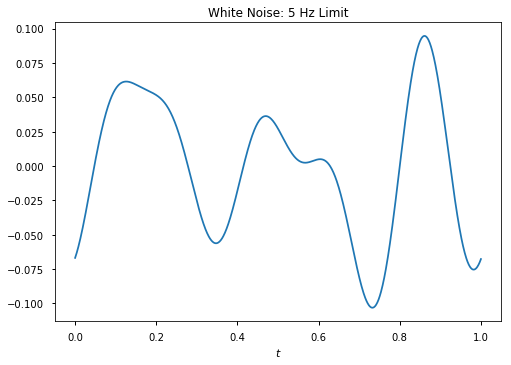

In [1352]:
T = 1
t = np.linspace(0, T, T/0.001)

sig5, SIG5 = generate_signal(T, 0.001, 0.05, 5, seed = 1)
figure()
plot(t,sig5)
title('White Noise: 5 Hz Limit')
xlabel('$t$');

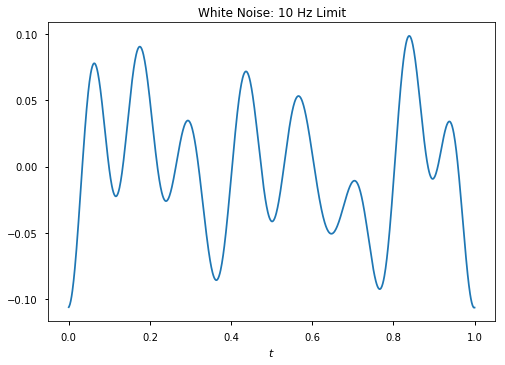

In [1353]:
sig10, SIG10 = generate_signal(1, 0.001, 0.05, 10, seed = 1)
figure()
plot(t,sig10)
title('White Noise: 10 Hz Limit')
xlabel('$t$');

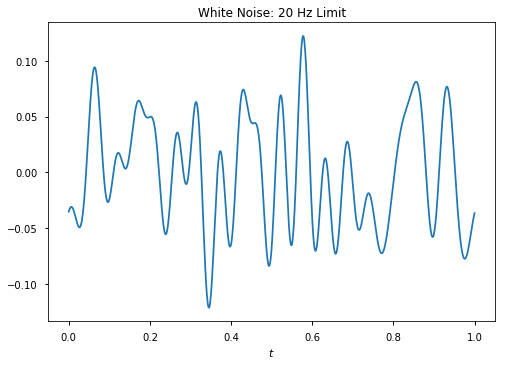

In [1354]:
sig20, SIG20 = generate_signal(1, 0.001, 0.05, 20, seed = 1)
figure()
plot(t,sig20)

title('White Noise: 20 Hz Limit')
xlabel('$t$');

<ol style="list-style:lower-alpha outside none;" start="2">
<li> [1 mark] Plot the average $|X(\omega)|$ (the norm of the Fourier coefficients) over 100 signals generated with  ``T``=1, ``dt``=0.001, ``rms``=0.5, and ``limit``=10 (each of these 100 signals should have a different ``seed``).  The plot should have the x-axis labeled ($\omega$ in radians) and the average $|X|$ value for that $\omega$ on the y-axis.</li>
</ol>

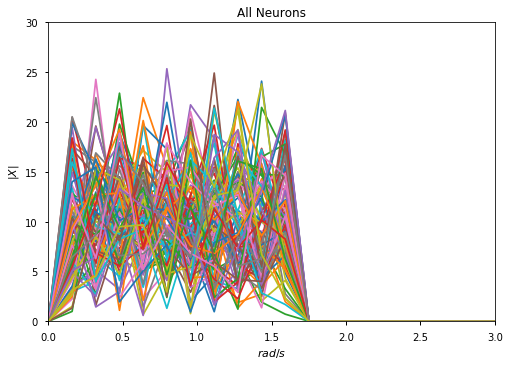

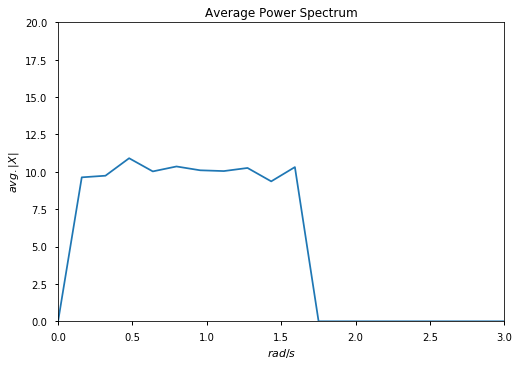

In [1355]:
SUM = np.zeros(SIG10.shape)
f = np.linspace(0,1/0.002, (1/(0.002)+1))
w = f/(2*pi)
figure()
for x in range(1,100):
    sig, SIG = generate_signal(1, 0.001, 0.05, 10,seed=x) # Generate a new random signal
    plot(w,SIG)
    SUM = SUM + SIG
AVG = SUM/x
ylim(0,30)
xlim(0,3)
title('All Neurons')
ylabel('$|X|$')
xlabel('$rad/s$');

figure()
plot(w, AVG)
ylim(0,20)
xlim(0,3)
title('Average Power Spectrum')
ylabel('$avg. |X|$')
xlabel('$rad/s$');

### 1.2) Gaussian power spectrum noise

Create a modified version of your function from question 1.1 that produces noise with a different power spectrum.  Instead of having the $X(\omega)$ values be 0 outside of some limit and sampled from $N(\mu=0,\sigma=1)$ inside that limit, we want a smooth drop-off of power as the frequency increases.  In particular, instead of the ``limit``, we sample from $N(\mu=0,\sigma=e^{-{\omega^2/(2*b^2)}})$ where $b$ is the new ``bandwidth`` parameter that replaces the ``limit`` parameter.

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[1 mark] Plot $x(t)$ for three randomly generated signals with ``bandwidth`` at 5, 10, and 20Hz.  For each of these, ``T``=1, ``dt``=0.001, and ``rms``=0.5.</li>
</ol>


In [1356]:
def generate_signal_gauss(T, dt, rms, bandwidth, seed=None):
    if (seed):
        np.random.seed(seed)
    Len = T/dt
    t = np.linspace(0,T,T/dt)
    sig = np.random.normal(0,1,t.shape)            # generate a random normal time domain signal (white noise)
    w_pos = np.linspace(0,len(t)/2, (T/(2*dt)+1))
    SIG = fft.rfft(sig)
    FILT = np.exp( -w_pos**2/(2*bandwidth**2) )    # generate a one sided gaussian filter
    FILT[0] = 0                                    # Set DC = 0
    SIG2 = SIG*FILT                                # Apply the filter
    
    sig2 = fft.irfft(SIG2)
    sig2 = sig2 * rms/getRMS(sig2)
    SIG2 = fft.rfft(sig2)
    
    return sig2, abs(SIG2)

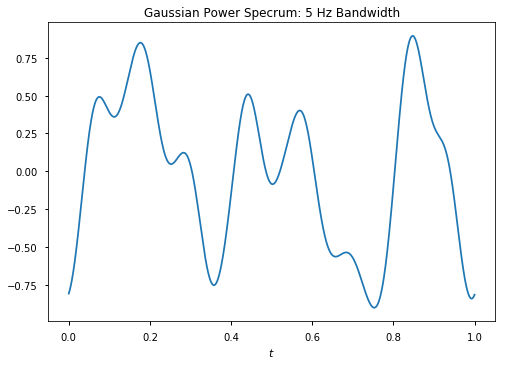

In [1357]:
sigpow5, SIGPOW5 = generate_signal_gauss(1, 0.001, 0.5, 5, seed = 1)
figure()
plot(t,sigpow5)
title('Gaussian Power Specrum: 5 Hz Bandwidth')
xlabel('$t$');

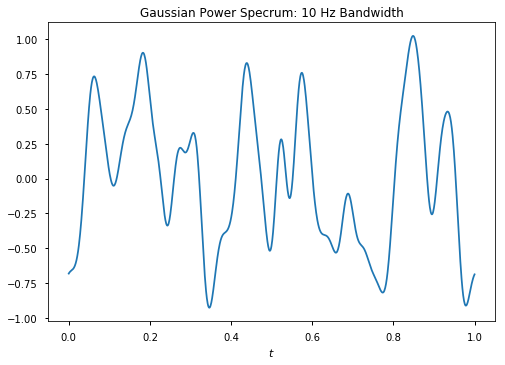

In [1358]:
sigpow10, SIGPOW10 = generate_signal_gauss(1, 0.001, 0.5, 10, seed = 1)
figure()
plot(t,sigpow10)
title('Gaussian Power Specrum: 10 Hz Bandwidth')
xlabel('$t$');

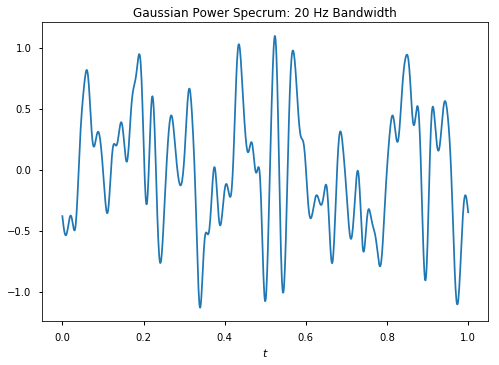

In [1359]:
sigpow20, SIGPOW20 = generate_signal_gauss(1, 0.001, 0.5, 20, seed = 1)
figure()
plot(t,sigpow20)
title('Gaussian Power Specrum: 20 Hz Bandwidth')
xlabel('$t$');

<ol style="list-style:lower-alpha outside none;" start="2">
<li>[1 mark] Plot the average $|X(\omega)|$ (the norm of the Fourier coefficients) over 100 signals generated with  ``T``=1, ``dt``=0.001, ``rms``=0.5, and ``bandwidth``=10 (each of these 100 signals should have a different ``seed``).</li>
</ol>

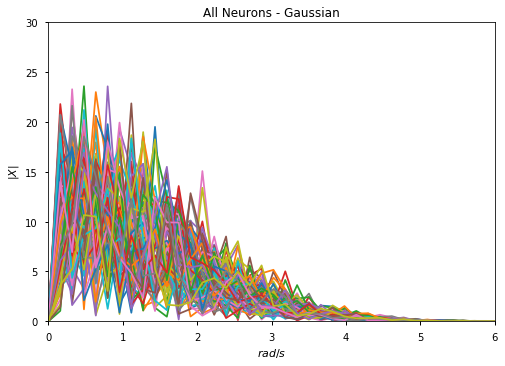

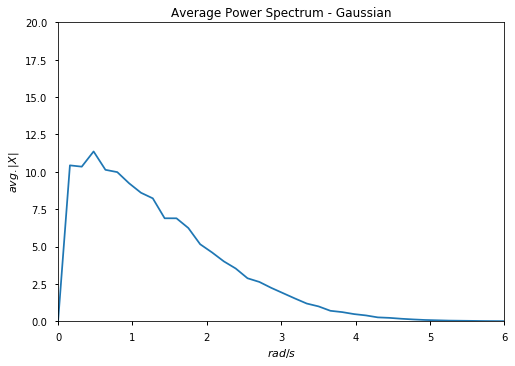

In [1360]:
SUM = np.zeros(SIG10.shape)
f = np.linspace(0,1/0.002, (1/(0.002)+1))
w = f/(2*pi)
figure()
for x in range(1,100):
    sig, SIG = generate_signal_gauss(1, 0.001, 0.05, 10, seed=x)
    plot(w,SIG)
    SUM = SUM + SIG
AVG = SUM/x
ylim(0,30)
xlim(0,6)
title('All Neurons - Gaussian')
ylabel('$|X|$')
xlabel('$rad/s$');

figure()
plot(w, AVG)
ylim(0,20)
xlim(0,6)
title('Average Power Spectrum - Gaussian')
ylabel('$avg. |X|$')
xlabel('$rad/s$');

## 2) Simulating a Spiking Neuron

Write a program to simulate a single Leaky-Integrate and Fire neuron.  The core equation is $ {{dV} \over {dt}} = {1 \over {\tau_{RC}}} (J - V)$ (to simplify life, this is normalized so that $R$=1, the resting voltage is 0 and the firing voltage is 1).  This equation can be simulated numerically by taking  small time steps (Euler's method).  When the voltage reaches the threshold $1$, the neuron will spike and then reset its voltage to $0$ for the next $\tau_{ref}$ amount of time (to plot this, place a dot or line at that time).  Also, if the voltage goes below zero at any time, reset it back to zero.  For this question, $\tau_{RC}$=0.02 and $\tau_{ref}$=0.002

Since we want to do inputs in terms of $x$, we need to do $J = \alpha e \cdot x + J^{bias}$.  For this neuron, set $e$ to $+1$ and find $\alpha$ and $J^{bias}$ such that the firing rate when $x=0$ is 40Hz and when $x=1$ it is 150Hz.  To find these $\alpha$ and $J^{bias}$ values, use the approximation for the LIF neuron $a(J)={1 \over {\tau_{ref}-\tau_{RC}ln(1-{1 \over J})}}$.

In [1361]:
def LIFcurve(tau_ref, tau_rc, J):
    A = np.zeros(J.shape)
    for x,j in enumerate(J):
        A[x] = (tau_ref - (tau_rc*np.log(1-j**(-1))))**(-1) if (j > 1) else 0
    return A

class singleNeuron():
    T = 0
    dt = 0.001
    encoder = 1
    x = np.linspace(0,1,1/dt)
    time = np.linspace(0,1,1/dt)
    alpha = 0
    jbias = 0
    J = 0
    a = 0
    V = 0
    dV = 0
    tau_rc = 0
    tau_ref = 0
    spikes = 0
    
    def __init__(self, T, tau_rc, tau_ref, dt, encoder):
       
    # initialize some variables
        self.encoder = encoder
        self.T = T
        self.dt = dt
        self.tau_rc = tau_rc
        self.tau_ref = tau_ref
        self.time = np.linspace(0,T,1/dt)
    
    # set the maximum & minumum firing rate
        maxFR = 150/(2*pi)
        minFR = 40/(2*pi)
        
    # calculate jbias and alpha given the max and min firing rates
        self.jbias = 1/(1-exp((tau_ref-1/minFR)/tau_rc))
        self.alpha = 1/(1-exp((tau_ref-1/maxFR)/tau_rc)) - self.jbias
        
        
        self.J = self.getJ(self.x)                        # Calculate the current as a funtion of input x
        self.a = LIFcurve(tau_ref, tau_rc, self.J) * 2*pi # Calculate the firing rate as a function of current
        
    def getJ(self,x):
        J = self.encoder * self.alpha * x + self.jbias
        return J
        
    def spikeTrain(self, x):
        n = np.int(self.T/self.dt)          # number of samples
        if isinstance(x, int):
            j = np.full([n], self.getJ(x))  # if our input signal is constant
        else:
            j = self.getJ(x)                # if input is a function of time
        
    # initialize our Spikes, Voltage and dV functions
        self.V = np.zeros([n])
        self.spikes = np.zeros([n])
        self.V[0] = 0
        self.dV = np.zeros([n])
    # Calculate dV and V for each time step
        for i in range(0,n):
            self.dV[i] = 2*pi/self.tau_rc * (j[i] - self.V[i]) * self.dt     # calculate dV given the previous V
            if i < len(self.V)-1:                                            # if we're not at the end
                self.V[i+1] = self.V[i] + self.dV[i]                         # calculate next V given dV and previous V
                if self.V[i+1] >= 1:                                         # if the next V will be over 1, we spike and set V to 0
                    self.V[i+1] = 0
                    self.spikes[i] = 1         
        return self.spikes

a. [1 mark] Plot the spike output for a constant input of $x=0$ over 1 second.  Report the number of spikes.  Do the same thing for $x=1$.  Use ``dt``=0.001 for the simulation.

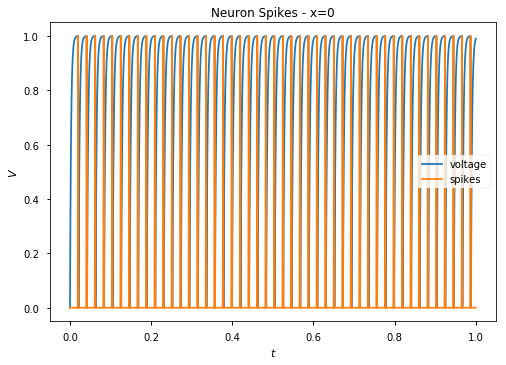

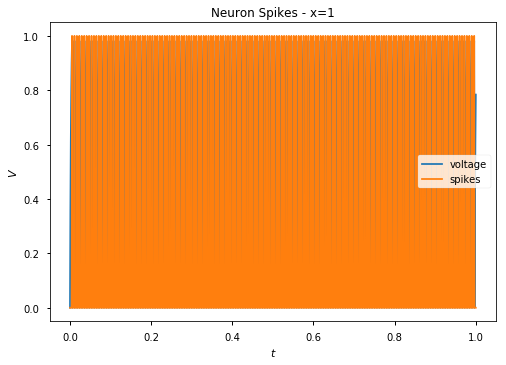

In [1362]:
neu = singleNeuron(T = 1,  dt = 0.001, tau_rc = 0.02, tau_ref = 0.002, encoder = 1)
neu.spikeTrain(x=0) 

figure()
plot(neu.time, neu.V, label="voltage")
plot(neu.time, neu.spikes, label="spikes")
title('Neuron Spikes - x=0')
legend(loc='best')
ylabel("$V$")
xlabel("$t$");

neu.spikeTrain(x=1)
figure()
plot(neu.time, neu.V, label="voltage")
plot(neu.time, neu.spikes, label="spikes")
title('Neuron Spikes - x=1')
legend(loc='best')
ylabel("$V$")
xlabel("$t$");

b. [1 mark] Does the observed number of spikes in the previous part match the expected number of spikes for $x=0$ and $x=1$?  Why or why not?  What aspects of the simulation would affect this accuracy?

> No, the observed number does not exactly match the expected 40 Hz and 150 Hz, but they are close. This is likely because of the stepwise integration, which can cause errors. It could also be because of the refactory period on the neuron, $\tau_{rc}$ 

c. [1 mark] Plot the spike output for $x(t)$ generated using your function from part 1.1.  Use ``T``=1, ``dt``=0.001, ``rms``=0.5, and ``limit``=30.  Overlay on this plot $x(t)$.

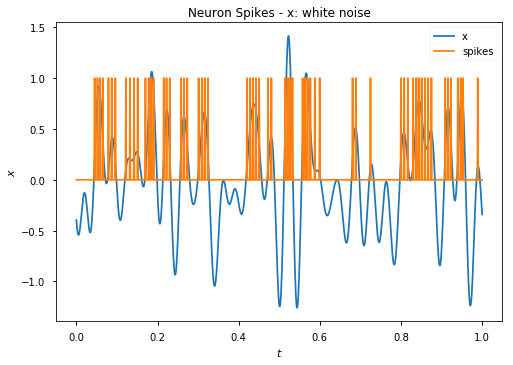

In [1363]:
neu = singleNeuron(T = 1, dt = 0.001, tau_rc = 0.02, tau_ref = 0.002, encoder = 1) # initiate a new neuron
X, FFT = generate_signal(T=1, dt=0.001, rms=0.5, limit=30, seed=1)                 # generate a random signal
neu.spikeTrain(x=X)                                                                # generate the spike train

t = np.linspace(0, 1,1/0.001)

figure()
plot(neu.time, X, label="x")
plot(neu.time, neu.spikes, label="spikes")
legend(loc='best')
title('Neuron Spikes - x: white noise')
ylabel("$x$");
xlabel("$t$");

d. [1 mark] Using the same $x(t)$ signal as in part (c), plot the neuron's voltage over time for the first 0.2 seconds, along with the spikes over the same time.

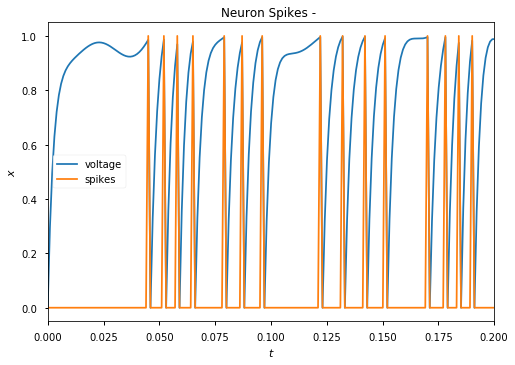

In [1364]:
figure()
plot(neu.time, neu.V, label="voltage")
plot(neu.time, neu.spikes, label="spikes")
title('Neuron Spikes - ')
legend(loc='best')
ylabel("$x$")
xlabel("$t$")
xlim(0,0.2);

e. BONUS: How could you improve this simulation (in terms of how closely the model matches actual equation) without significantly increasing the computation time?  0.5 marks for having a good idea, and up to 1 marks for actually implementing it and showing that it works.

## 3) Simulating Two Spiking Neurons

Write a program that simulates two neurons.  The two neurons have exactly the same parameters, except for one of them $e=1$ and for the other $e=-1$.  Other than that, use exactly the same settings as in question 2.

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[0.5 marks] Plot $x(t)$ and the spiking output for $x(t)=0$ (both neurons should spike at ~40 spikes per second).</li>
</ol>

In [1365]:
# Neuron Pair Class (extends singleNeuron)
class twoNeurons():
    pos = 0
    neg = 0
    time = 0
    def __init__(self, T, dt, tau_rc, tau_ref):
        # create the positive encoded single neuron
        self.pos = singleNeuron(T = T, dt = dt, tau_rc = tau_rc, tau_ref = tau_ref, encoder = 1)
        # create the negative encoded single neuron
        self.neg = singleNeuron(T = T, dt = dt, tau_rc = tau_rc, tau_ref = tau_ref, encoder = -1)
        self.time = self.pos.time
    
    def spikeTrains(self, x):
        # return a 2xN matrix of spike trains 
        return [self.pos.spikeTrain(x), self.neg.spikeTrain(x)]
        
neupair = twoNeurons(T = 1, dt = 0.001, tau_rc = 0.02, tau_ref = 0.002) # create the neuron pair

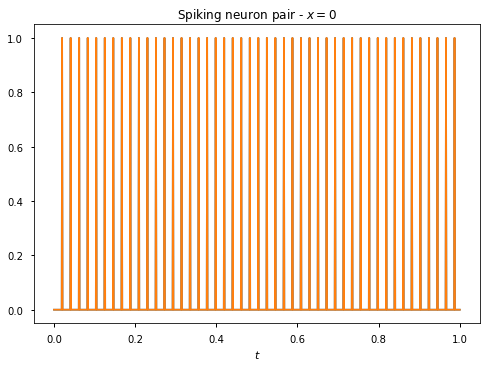

In [1366]:
neupair.spikeTrains(x=0) # calculate the spike trains of both neurons

figure()
plot(neupair.time, neupair.spikeTrains(0)[0])
plot(neupair.time, neupair.spikeTrains(0)[1])
title('Spiking neuron pair - $x=0$')
xlabel('$t$');

<ol style="list-style:lower-alpha outside none;" start="2">
<li>[0.5 marks] Plot $x(t)$ and the spiking output for $x(t)=1$ (one neuron should spike at ~150 spikes per second, and the other should not spike at all).</li>

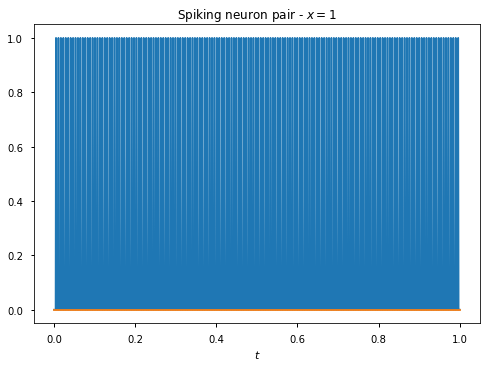

In [1367]:
neupair.spikeTrains(x=1)

figure()
plot(neupair.time, neupair.pos.spikes)
plot(neupair.time, neupair.neg.spikes)
title('Spiking neuron pair - $x=1$')
xlabel('$t$');

<ol style="list-style:lower-alpha outside none;" start="3">
<li>[1 mark] Plot $x(t)$ and the spiking output for $x(t)={1 \over 2}sin(10\pi t)$ (a sine wave at 5Hz).</li>

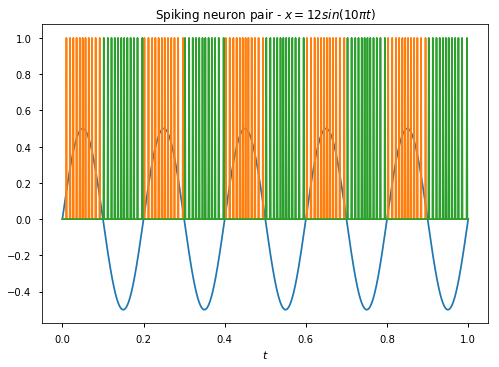

In [1368]:
sine = 0.5*np.sin(10*pi*neupair.time)

neupair.spikeTrains(x=sine)

figure()
plot(neupair.time,sine)
plot(neupair.time, neupair.pos.spikes)
plot(neupair.time, neupair.neg.spikes)
title('Spiking neuron pair - $x=12sin(10\pi t)$')
xlabel('$t$');

<ol style="list-style:lower-alpha outside none;" start="4">
<li>[1 mark] Plot $x(t)$ and the spiking output for a random signal generated with your function for question 1.1 with ``T``=2, ``dt``=0.001, ``rms``=0.5, and ``limit``=5.</li>
</ol>

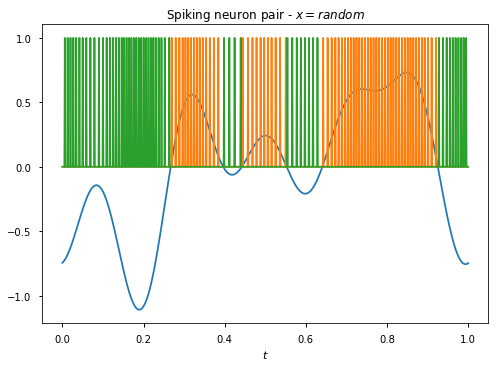

In [1369]:
sig3d, SIG3D = generate_signal(T=1, dt=0.001, rms=0.5, limit=5, seed=12)    # generate a bandlimited signal

neupair3d = twoNeurons(T = 1, dt = 0.001, tau_rc = 0.02, tau_ref = 0.002)   # create the neuron pair
neupair3d.spikeTrains(x=sig3d)                                              #calculate the spike trains

#plot the spike trains
figure()
plot(neupair3d.time,sig3d)
plot(neupair3d.time, neupair3d.pos.spikes)
plot(neupair3d.time, neupair3d.neg.spikes)
title('Spiking neuron pair - $x=random$')
xlabel('$t$');

 ## 4) Computing an Optimal Filter

Compute the optimal filter for decoding pairs of spikes.  Instead of implementing this yourself, here is an implementation in <a href="files/assignment2/optimal_filter.py">Python</a> and an implementation in <a href="files/assignment2/optimal_filter.m">Matlab</a>.  

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[1 mark] Document the code and connect it with the code you wrote for part (3) so that it uses the signal used in 3.d.  Comments should be filled in where there are ``#`` signs (Python) or ``%`` signs (Matlab).  Replace the ``'???'`` labels in the code with the correct labels.  Note that you can use the generated plots for the next few parts of this question.</li>

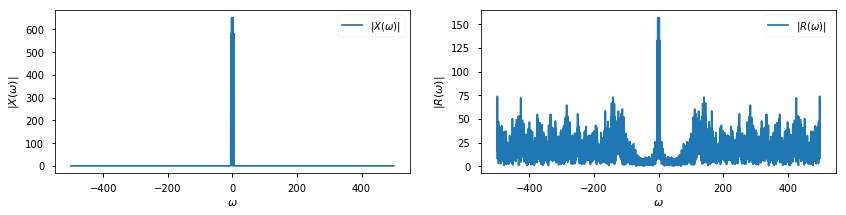

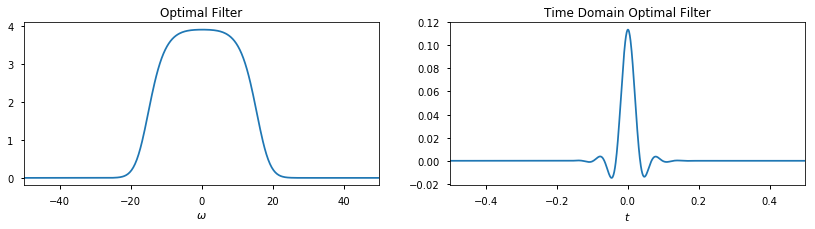

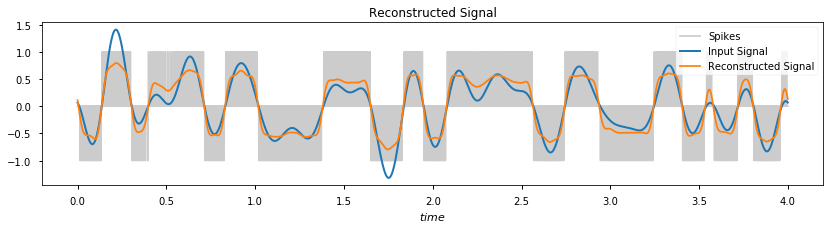

In [1383]:
T = 4.0         # length of signal in seconds
dt = 0.001      # time step size

# Generate bandlimited white noise (use your own function from part 1.1)
x, X = generate_signal(T, dt, rms=0.5, limit=5, seed=3)
X = fft.fftshift(fft.fft(x))    # generate_signal returns rfft

Nt = len(x)                # Number of time samples
t = np.arange(Nt) * dt     # Set the time array

# Neuron parameters
tau_ref = 0.002          # The refactory time constant
tau_rc = 0.02            # The RC time constant
x0 = 0.0                 # firing rate at x=x0 is a0
a0 = 40.0
x1 = 1.0                 # firing rate at x=x1 is a1
a1 = 150.0

# Calculate Gain and Bias of Neurons
eps = tau_rc/tau_ref
r1 = 1.0 / (tau_ref * a0)
r2 = 1.0 / (tau_ref * a1)
f1 = (r1 - 1) / eps
f2 = (r2 - 1) / eps
alpha = (1.0/(numpy.exp(f2)-1) - 1.0/(numpy.exp(f1)-1))/(x1-x0) 
x_threshold = x0-1/(alpha*(numpy.exp(f1)-1))              
Jbias = 1-alpha*x_threshold;   

# Simulate the two neurons (use your own function from part 3)
two_neurons = twoNeurons(T = 4, dt = dt, tau_rc = tau_rc, tau_ref = tau_ref)
spikes = two_neurons.spikeTrains(x=x)

freq = np.arange(Nt)/T - Nt/(2.0*T)      # Set the Frequency array (in Hz) for plotting
omega = freq*2*pi                        # Convert the Frequency array to rad/s

r = spikes[0] - spikes[1]                # Calculate the difference of spikes to get 1-dimensional spike train signal
R = fft.fftshift(fft.fft(r))             # FFT of spike train signal

sigma_t = 0.025                          # Stdev of window size
W2 = np.exp(-omega**2*sigma_t**2)        # Create gaussian window
W2 = W2 / sum(W2)                        # Normalize window function to an area of 1

CP = X*R.conjugate()                  # Numerator for filter transfer function H
WCP = np.convolve(CP, W2, 'same')     # Time domain window of the numerator 
RP = R*R.conjugate()                  # Denominator for filter transfer function H. |R(w)|^2
WRP = np.convolve(RP, W2, 'same')     # Time domain window of the numerator 
XP = X*X.conjugate()                  # Square of X |X(w)|^2
WXP = np.convolve(XP, W2, 'same')     # Time domain window of the above line

H = WCP / WRP                         # Calculate the optimal filter

h = fft.fftshift(fft.ifft(fft.ifftshift(H))).real  # Convert filter to time domain 

XHAT = H*R                            # Decode the spike train

xhat = fft.ifft(fft.ifftshift(XHAT)).real  # Convert decoded signal to time domain

import pylab

pylab.figure(1)
figsize(14,3)
pylab.subplot(1,2,1)
pylab.plot(freq, np.sqrt(XP), label='$|X(\omega)|$')  # Plot vector norm of input signal in frequency domain
pylab.legend()
pylab.xlabel('$\omega$')
pylab.ylabel('$|X(\omega)|$')

pylab.subplot(1,2,2)
pylab.plot(freq, np.sqrt(RP), label='$|R(\omega)|$')  # Plot vector norm of spike train in frequency domain
pylab.legend()
pylab.xlabel('$\omega$')
pylab.ylabel('$|R(\omega)|$')

pylab.figure(2)
figsize(14,3)
pylab.subplot(1,2,1)
pylab.plot(freq, H.real)   # Plot the real part of the Optimal filter
pylab.xlabel('$\omega$')
pylab.title('Optimal Filter')
pylab.xlim(-50, 50)

pylab.subplot(1,2,2)
pylab.plot(t-T/2, h)       # Plot the optimal filter in time domain
pylab.title('Time Domain Optimal Filter')
pylab.xlabel('$t$')
pylab.xlim(-0.5, 0.5)

pylab.figure(3)
figsize(14,3)
pylab.plot(t, r, color='k', label='Spikes', alpha=0.2)  # Plot the spike train
pylab.plot(t, x, linewidth=2, label='Input Signal')           # Plot the input signal
pylab.plot(t, xhat, label='Reconstructed Signal')             # Plot the reconstructed signal from spike trains
pylab.title('Reconstructed Signal')
pylab.legend(loc='best')
pylab.xlabel('$time$')

pylab.show()

<ol style="list-style:lower-alpha outside none;" start="2">
<li>[1 mark] Plot the time and frequency plots for the optimal filter for the signal you generated in question 3.d.</li>
</ol>

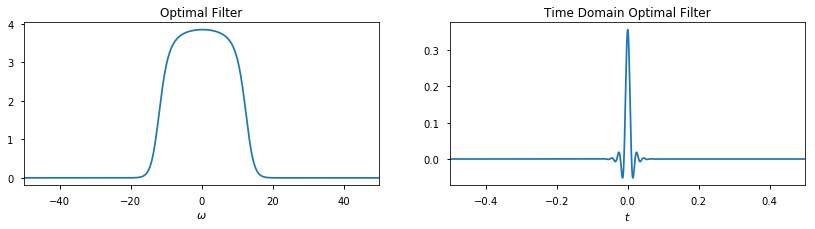

In [1371]:
sig3d, SIG3D = generate_signal(T = 1, dt=0.001, rms=0.5, limit=5, seed=12)
SIG3D = fft.fftshift(fft.fft(sig3d))
neupair3d = twoNeurons(T = 1, dt = 0.001, tau_rc = 0.02, tau_ref = 0.002)
spikes = neupair3d.spikeTrains(x=sig3d)

Nt = len(sig3d)
t = np.arange(Nt) * dt     # Set the time array
freq = np.arange(Nt)/T - Nt/(2.0*T)      # Set the Frequency array (in Hz) for plotting
omega = freq*2*pi                        # Convert the Frequency array to rad/s

r = spikes[0] - spikes[1]                # Calculate the difference of spikes to get 1-dimensional spike train signal
R = fft.fftshift(fft.fft(r))             # FFT of spike train signal

sigma_t = 0.025                          # Stdev of window size
W2 = np.exp(-omega**2*sigma_t**2)        # Create gaussian window
W2 = W2 / sum(W2)                        # Normalize window function to an area of 1

CP = SIG3D*R.conjugate()                  # Numerator for filter transfer function H
WCP = np.convolve(CP, W2, 'same')     # Time domain window of the numerator 
RP = R*R.conjugate()                  # Denominator for filter transfer function H. |R(w)|^2
WRP = np.convolve(RP, W2, 'same')     # Time domain window of the numerator 
XP = SIG3D*SIG3D.conjugate()                  # Square of X |X(w)|^2
WXP = np.convolve(XP, W2, 'same')     # Time domain window of the above line

H = WCP / WRP                         # Calculate the optimal filter

h = fft.fftshift(fft.ifft(fft.ifftshift(H))).real  # Convert filter to time domain 

XHAT = H*R  # Decode the spike train

xhat = fft.ifft(fft.ifftshift(XHAT)).real  # Convert decoded signal to time domain

import pylab

pylab.figure()
figsize(14,3)
pylab.subplot(1,2,1)
pylab.plot(freq, H.real)   # Plot the real part of the Optimal filter
pylab.xlabel('$\omega$')
pylab.title('Optimal Filter')
pylab.xlim(-50, 50)

pylab.subplot(1,2,2)
pylab.plot(t-0.5,h)       # Plot the positive time portion of the optimal filter in time domain
pylab.title('Time Domain Optimal Filter')
pylab.xlabel('$t$')
pylab.xlim(-0.5, 0.5)

pylab.show()

<ol style="list-style:lower-alpha outside none;" start="3">
<li>[1 marks] Plot the $x(t)$ signal, the spikes, and the decoded $\hat{x}(t)$ value for the signal in question 3.d.</li>
</ol>

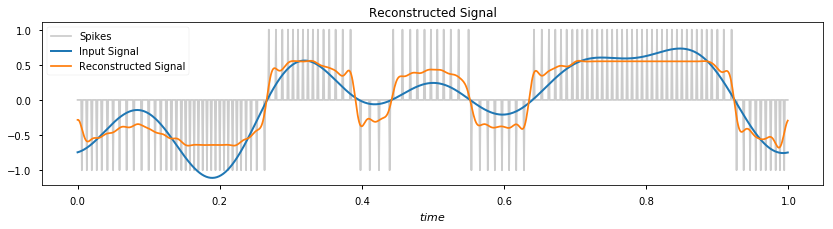

In [1372]:
pylab.figure()
pylab.plot(t, r, color='k', label='Spikes', alpha=0.2)  # Plot the spike train
pylab.plot(t, sig3d, linewidth=2, label='Input Signal')           # Plot the input signal
pylab.plot(t, xhat, label='Reconstructed Signal')             # Plot the reconstructed signal from spike trains
pylab.title('Reconstructed Signal')
pylab.legend(loc='best')
pylab.xlabel('$time$')
pylab.show();

<ol style="list-style:lower-alpha outside none;" start="4">
<li>[1 marks] Plot the $|X(\omega)|$ power spectrum, $|R(\omega)|$ spike response spectrum, and the $|\hat{X}(\omega)|$ power spectrum for the signal in question 3.d. How do these relate to the optimal filter?</li>
</ol>

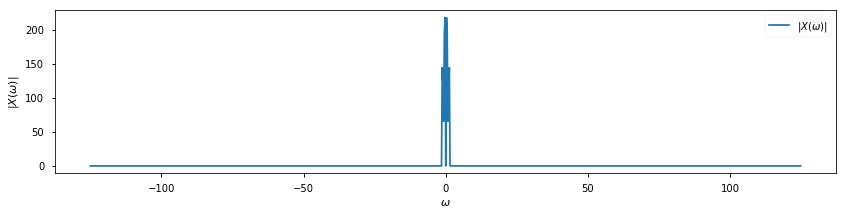

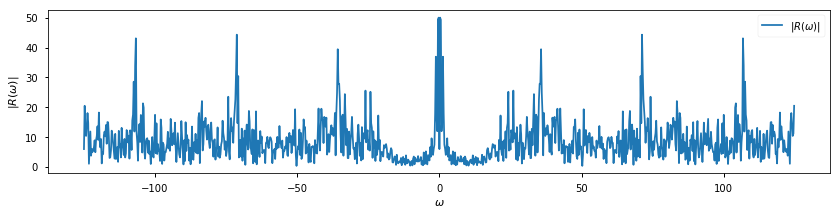

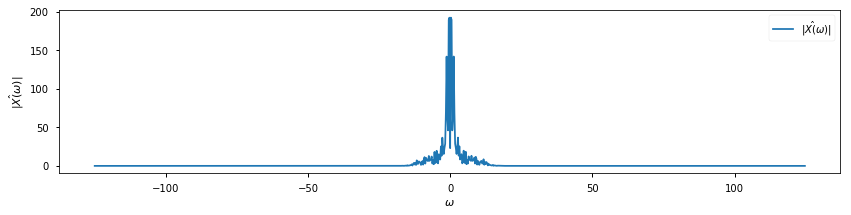

In [1373]:
pylab.figure()
pylab.plot(freq, np.sqrt(XP), label='$|X(\omega)|$')  # Plot vector norm of input signal in frequency domain
pylab.legend()
pylab.xlabel('$\omega$')
pylab.ylabel('$|X(\omega)|$')

pylab.figure()
pylab.plot(freq, np.sqrt(RP), label='$|R(\omega)|$')  # Plot vector norm of spike train in frequency domain
pylab.legend()
pylab.xlabel('$\omega$')
pylab.ylabel('$|R(\omega)|$')

pylab.figure()
pylab.plot(freq, np.sqrt(XHAT*XHAT.conjugate()), label='$|X\hat(\omega)|$')  # Plot vector norm of spike train in frequency domain
pylab.legend()
pylab.xlabel('$\omega$')
pylab.ylabel('$|X\hat(\omega)|$')

pylab.show()

<ol style="list-style:lower-alpha outside none;" start="5">
<li>[1 mark] Generate $h(t)$ time plots for the optimal filter for different ``limit`` values of 2Hz, 10Hz, and 30Hz.  Describe the effects on the time plot of the optimal filter as the ``limit`` increases.  Why does this happen?</li>
</ol>

In [1374]:
def optimalFilter(T, dt, tau_rc, tau_ref, limit, seed):

    # Generate bandlimited white noise (use your own function from part 1.1)
    x, X = generate_signal(T = T, dt=dt, rms=0.5, limit=limit, seed = seed)
    X = fft.fftshift(fft.fft(x))    # generate_signal returns rfft

    Nt = len(x)                # Number of time samples
    t = np.arange(Nt) * dt     # Set the time array
    
    # Simulate the two neurons (use your own function from part 3)
    two_neurons = twoNeurons(T = T, dt = dt, tau_rc = tau_rc, tau_ref = tau_ref)
    spikes = two_neurons.spikeTrains(x=x)

    freq = np.arange(Nt)/T - Nt/(2.0*T)      # Set the Frequency array (in Hz) for plotting
    omega = freq*2*pi                        # Convert the Frequency array to rad/s

    r = spikes[0] - spikes[1]                # Calculate the difference of spikes to get 1-dimensional spike train signal
    R = fft.fftshift(fft.fft(r))             # FFT of spike train signal

    sigma_t = 0.025                          # Stdev of window size
    W2 = np.exp(-omega**2*sigma_t**2)        # Create gaussian window
    W2 = W2 / sum(W2)                        # Normalize window function to an area of 1

    CP = X*R.conjugate()                  # Numerator for filter transfer function H
    WCP = np.convolve(CP, W2, 'same')     # Time domain window of the numerator 
    RP = R*R.conjugate()                  # Denominator for filter transfer function H. |R(w)|^2
    WRP = np.convolve(RP, W2, 'same')     # Time domain window of the numerator 
    XP = X*X.conjugate()                  # Square of X |X(w)|^2
    WXP = np.convolve(XP, W2, 'same')     # Time domain window of the above line

    H = WCP / WRP                         # Calculate the optimal filter

    h = fft.fftshift(fft.ifft(fft.ifftshift(H))).real  # Convert filter to time domain 

    XHAT = H*R                            # Decode the spike train

    xhat = fft.ifft(fft.ifftshift(XHAT)).real  # Convert decoded signal to time domain
    
    return t, x, xhat

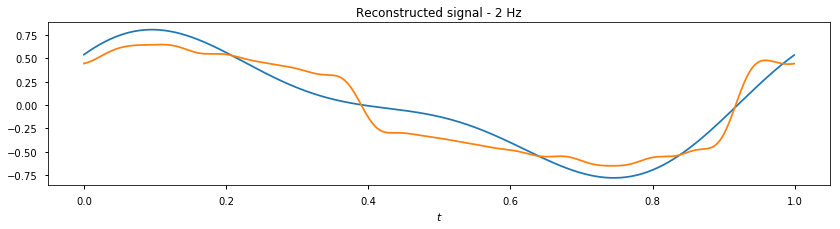

In [1375]:
# 2 Hz
t, x, xhat = optimalFilter(T = 1, dt = 0.001, tau_rc = 0.02, tau_ref = 0.002, limit = 2, seed = 1)

figure()
plot(t,x)
plot (t,xhat)
title('Reconstructed signal - 2 Hz')
xlabel('$t$');

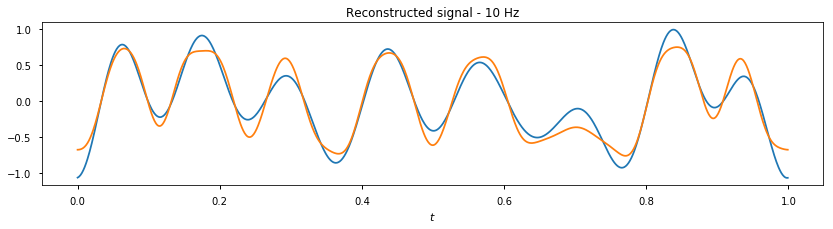

In [1376]:
# 10 Hz
t, x, xhat = optimalFilter(T = 1, dt = 0.001, tau_rc = 0.02, tau_ref = 0.002, limit = 10, seed = 1)

figure()
plot(t,x)
plot (t,xhat)
title('Reconstructed signal - 10 Hz')
xlabel('$t$');

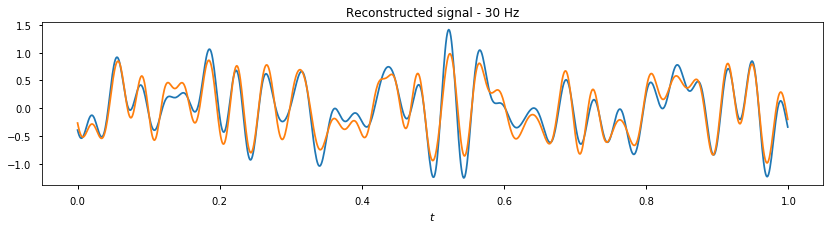

In [1377]:
# 30 Hz
t, x, xhat = optimalFilter(T = 1, dt = 0.001, tau_rc = 0.02, tau_ref = 0.002, limit = 30, seed = 1)

figure()
plot(t,x)
plot (t,xhat)
title('Reconstructed signal - 30 Hz')
xlabel('$t$');

> As the limit increases, the regenerated signal follows the original signal better. This is because...

## 5) Using Post-Synaptic Currents as a Filter

Instead of using the optimal filter from the previous question, now we will use the post-synaptic current instead.  This is of the form $h(t)=t^n e^{-t/\tau}$ normalized to area 1.

In [1378]:
def synapticFilter(T, dt, tau_rc, tau_ref, limit, seed, n, tau, out=None, decoder=None):
    
    # Generate bandlimited white noise
    x, X = generate_signal(T = T, dt=dt, rms=0.5, limit=limit, seed = seed)
    Nt = len(x)                # Number of time samples
    t = np.arange(Nt) * dt     # Set the time array
  
    # Create the filter
    h = t**n * np.exp(-t/tau)
    h = h / sum(h) 
    H = (fft.rfft(h))
    
    if out == 'h':
        return t, h
    
    # Simulate the two neurons
    two_neurons = twoNeurons(T = T, dt = dt, tau_rc = tau_rc, tau_ref = tau_ref)
    spikes = two_neurons.spikeTrains(x=x)
    SPIKES = [(fft.rfft(spikes[0])), (fft.rfft(spikes[1]))]
    
    # Apply the filter
    FSPIKES = [H*SPIKES[0], H*SPIKES[1]]
    fspikes = [fft.irfft((FSPIKES[0])), fft.irfft((FSPIKES[1]))]
    
    # Calculate the encoders
    A = np.array(fspikes)
    try:
        if decoder:
            d = decoder
        else:
            d = decode(A, x, dt, noise=True)
    except:
        d = decode(A, x, dt, noise=True)
        
    # Decode the spike train 
    xhat = np.dot(np.transpose(A), d)
    
    if out == 'x':
        return t, x, xhat
    else:
        return t, h, x, xhat, fspikes, d
    
def decode(A, x, dt, noise=None):
    Ypsilon = dt * np.matmul(A,x)
    Gamma = dt * np.matmul(A, np.transpose(A))
    if noise:
        Var = np.power(0.2 * np.max(A),2) * np.identity(A.shape[0])
        Gamma += Var
    Gamma_inv = np.linalg.inv(Gamma)
    d = np.dot(Gamma_inv, Ypsilon) 
    d = np.transpose(np.matrix([d]))
    return d

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[1 mark] Plot the normalized $h(t)$ for $n$=0, 1, and 2 with $\tau$=0.007 seconds.  What two things do you expect increasing $n$ will do to $\hat{x}(t)$?</li>
</ol>

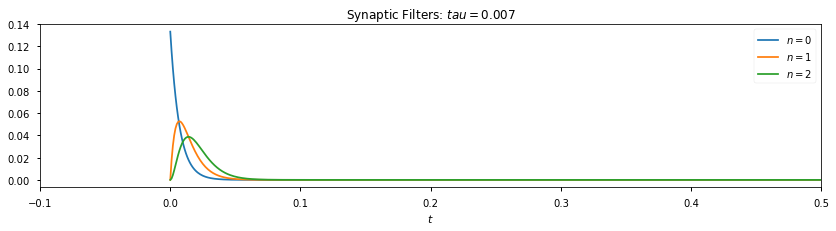

In [1379]:
figure()
t, h = synapticFilter(T=1, dt=0.001, tau_rc=0.02, tau_ref=0.002, limit=10, seed=1, n=0, tau=0.007, out = 'h')
plot(t,h, label="$n=0$")
t, h = synapticFilter(T=1, dt=0.001, tau_rc=0.02, tau_ref=0.002, limit=10, seed=1, n=1, tau=0.007, out = 'h')
plot(t,h, label='$n=1$')
t, h = synapticFilter(T=1, dt=0.001, tau_rc=0.02, tau_ref=0.002, limit=10, seed=1, n=2, tau=0.007, out = 'h')
plot(t,h, label = '$n=2$')
xlabel('$t$')
pylab.legend(loc='best')
title('Synaptic Filters: $tau = 0.007$')
xlim(-0.1,0.5);

> Expect these will cause a delay in the output signal, proportional to n.

<ol style="list-style:lower-alpha outside none;" start="2">
<li>[1 mark] Plot the normalized $h(t)$ for $\tau$=0.002, 0.005, 0.01, and 0.02 seconds with $n$=0.  What two things do you expect increasing $\tau$ will do to $\hat{x}(t)$?</li>
</ol>

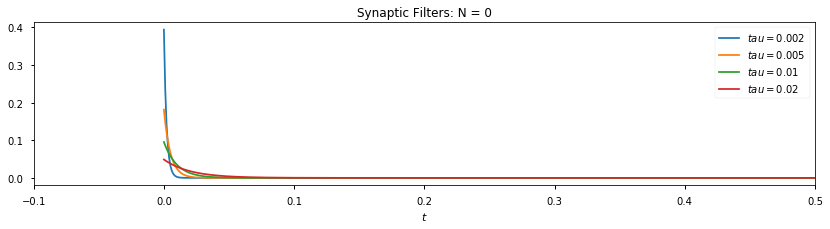

In [1380]:
figure()
t, h = synapticFilter(T=1, dt=0.001, tau_rc=0.02, tau_ref=0.002, limit=10, seed=1, n=0, tau=0.002, out = 'h')
plot(t,h, label='$tau=0.002$')

t, h = synapticFilter(T=1, dt=0.001, tau_rc=0.02, tau_ref=0.002, limit=10, seed=1, n=0, tau=0.005, out = 'h')
plot(t,h, label = '$tau=0.005$')

t, h = synapticFilter(T=1, dt=0.001, tau_rc=0.02, tau_ref=0.002, limit=10, seed=1, n=0, tau=0.01, out = 'h')
plot(t,h, label = '$tau=0.01$')

t, h = synapticFilter(T=1, dt=0.001, tau_rc=0.02, tau_ref=0.002, limit=10, seed=1, n=0, tau=0.02, out = 'h')
plot(t,h, label = '$tau=0.02$')

xlabel('$t$')
pylab.legend(loc='best')
title('Synaptic Filters: N = 0')
xlim(-0.1,0.5);

> Expect there will be more of a blur effect, where past inputs matter more, as $\tau$ increases. The output signal will be much smoother and low-passed

<ol style="list-style:lower-alpha outside none;" start="3">
<li>[1 mark] Decode $\hat{x}(t)$ from the spikes generated in question 3.d using an $h(t)$ with $n$=0 and $\tau$=0.007.  Do this by generating the spikes, filtering them with $h(t)$, and using that as your activity matrix $A$ to compute your decoders.  Plot the time and frequency plots for this $h(t)$.  Plot the $x(t)$ signal, the spikes, and the decoded $\hat{x}(t)$ value.</li>
</ol>

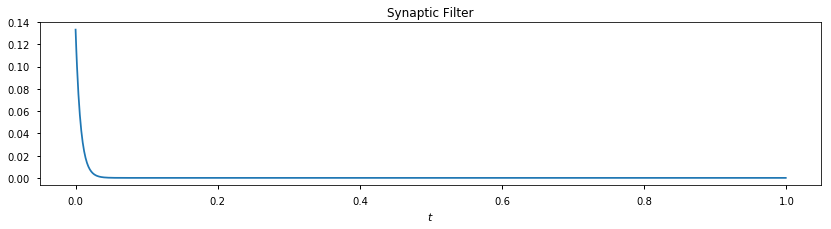

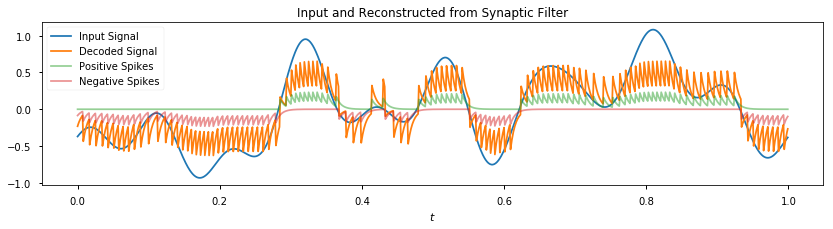

In [1381]:
t, h, x, xhat, spikes, d = synapticFilter(T=1, dt=0.001, tau_rc=0.02, tau_ref=0.002, limit=10, seed=12, n=0, tau=0.007)
figure()
plot(t, h)
title('Synaptic Filter')
xlabel('$t$');

figure()
plot(t, x, label="Input Signal")
plot(t,xhat, label="Decoded Signal")
plot(t, spikes[0], alpha=0.5, label="Positive Spikes")
plot(t, -spikes[1], alpha=0.5, label="Negative Spikes")
title('Input and Reconstructed from Synaptic Filter')
pylab.legend(loc='best')
xlabel('$t$');

<ol style="list-style:lower-alpha outside none;" start="4">
<li>[1 mark] Use the same decoder and $h(t)$ as in part (c), but generate a new $x(t)$ with ``limit``=2Hz.  Plot the $x(t)$ signal, the spikes, and the decoded $\hat{x}(t)$ value.  How do these decodings compare?</li>
</ol>

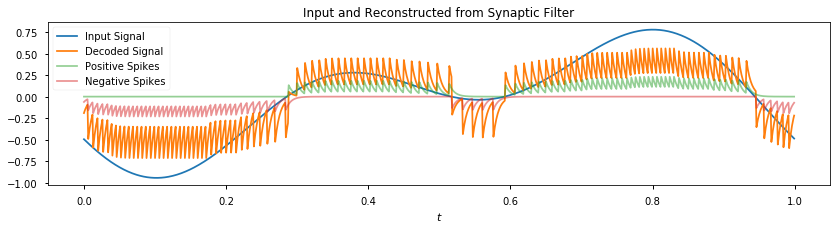

In [1382]:
t, h, x, xhat, spikes, d = synapticFilter(T=1, dt=0.001, tau_rc=0.02, tau_ref=0.002, limit=2, seed=12, n=0, tau=0.007, decoder = d)

figure()
plot(t, x, label="Input Signal")
plot(t,xhat, label="Decoded Signal")
plot(t, spikes[0], alpha=0.5, label="Positive Spikes")
plot(t, -spikes[1], alpha=0.5, label="Negative Spikes")
title('Input and Reconstructed from Synaptic Filter')
pylab.legend(loc='best')
xlabel('$t$');

> The decoding of the lower frequency signal causes more apparent noise, but less of a noticable lag in the signal